
# ARSENL Backscatter Experiments

Grant Kirchhoff
06-23-2022
University of Colorado Boulder

Fit the photon arrival rate to exponentiated polynomial profiles from ARSENL INPHAMIS lidar. 

IMPORTANT: Set data path settings in
'load_ARSENL_data.py' first.

In [120]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr

In [138]:
### CONSTANTS ####
c = 299792458                      # [m/s] Speed of light
tstamp_int = 25                    # Timestamp interval (e.g., timestamp recorded in intervals of 25)
max_rollover = 2**25 * tstamp_int  # [ps] the maximum timestamp before instrument timer rolls over
scale = 1e-12                      # Scale from psec --> sec

### PARAMETERS ###
exclude_bnd = [30e-9, 32e-9]       # [s] Set boundaries for binning to exclude outliers
exclude = True                     # Set TRUE to exclude data to work with smaller dataset
excl_val = 10000                   # Include up to certain sample number
deadtime = 8e-9                  # [s] Acquisition deadtime

cwd = os.getcwd()
data_dir = cwd + r'/../Data/Deadtime_Experiments_HiFi'
fname = r'/Dev_0_-_2022-04-15_11.02.33.ARSENL.OD05.ARSENL.nc'

In [139]:
# Load and organize xarray dataset
ds = xr.open_dataset(data_dir + fname)

flight_time = ds.time_tag * tstamp_int * scale  # [s] Convert time tags to flight times
flight_time = flight_time[np.where((flight_time >= exclude_bnd[0]) \
                                   & (flight_time < exclude_bnd[1]))]  # Exclude specified t.o.f. bins
tstamp_diff = ds.time_tag_diff * tstamp_int * scale  # [s] Elapsed time since previous time tag

if exclude:
    flight_time = flight_time[0:excl_val]
    tstamp_diff = tstamp_diff[0:excl_val]
    
    init_sync_cnt = ds.sync_index[0].item()  # Grab initial sync counter value
    num_syncs = ds.time_tag_sync_index[excl_val].item() - init_sync_cnt  # Normalize counter values to start at 0 (then increment by 1s)
    cnt_phot = num_syncs
else:
    cnt_phot = len(ds.sync_index)

In [140]:
ds

<xarray.Dataset>
Dimensions:              (time_tag_index: 1104025, sync_index: 1189057)
Coordinates:
  * sync_index           (sync_index) uint64 3587136 3587137 ... 4776191 4776192
Dimensions without coordinates: time_tag_index
Data variables:
    time_tag             (time_tag_index) int64 1247 1256 1245 ... 1252 1239
    time_tag_diff        (time_tag_index) int64 2592712 2799247 ... 2828214
    time_tag_sync_index  (time_tag_index) uint64 ...
    sync_ux_time         (sync_index) datetime64[ns] ...
    sync_ux_time_us      (sync_index) timedelta64[ns] ...
    sync_diff_time       (sync_index) int64 ...
    sync_delta           (sync_index) int64 ...

In [141]:
(ds.sync_delta * 25 * 1e-12)

<xarray.DataArray 'sync_delta' (sync_index: 1189057)>
array([-1.50243425e-04,  6.99193750e-05,  6.98966750e-05, ...,
        7.06896000e-05,  7.07276000e-05,  7.06533750e-05])
Coordinates:
  * sync_index  (sync_index) uint64 3587136 3587137 3587138 ... 4776191 4776192

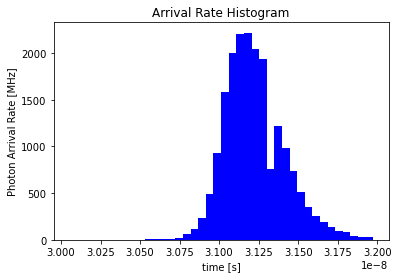

In [123]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
n, bin_edges = np.histogram(flight_time, bins=40)
binwidth = np.diff(bin_edges)[0]
N = n / binwidth / cnt_phot  # [Hz] Scale counts to arrival rate
center = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.bar(center, N/1e6, align='center', width=binwidth, color='b')
ax.set_title('Arrival Rate Histogram')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
plt.show()

In [124]:
# plt.figure()
# plt.stem(flight_time, np.ones(flight_time.size))
# plt.title('Photons')
# plt.xlabel('Time [ps]')
# plt.show()

### Now applying the curve_fit routine to my data. Code pulled from Matt Hayman's "Fit_TimeTag_Gaussian.ipynb" and adapted to fit to arbitrary exponentiated polynomials.

In [92]:
# Chebyshev polynomial matrix generator
def cheby_poly(x, M):
    """
    Parameters:
    x (torch array): Values to be evaluated on in chebyshev polynomial      \\ [Nx1]
    M (int)        : *Highest* order term of polynomial (e.g., x^2 --> M=2) \\ []
    Returns:
    chebyshev polynomial matrix (torch array): Evaluated polynomial \\ [NxM]
    """
    
    def cheby(x, m):
        """
        Helper to calculate value of specific chebyshev order
        """
        T0 = x**0
        T1 = x**1
        if m == 0:   return T0
        elif m == 1: return T1
        else:        return 2*x*cheby(x, m-1) - cheby(x, m-2)
    
    N = len(x)
    model_out = torch.zeros((N, M+1), dtype=float)
    for i in range(M+1):
        model_out[:, i] = cheby(x, i)
    
    return model_out

In [100]:
# build the fit model as a NN module
class Fit_Pulse(torch.nn.Module):
    def __init__(self, M, t_min, t_max, deadtime):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.M = M          # Polynomial order
        self.C = torch.nn.Parameter(-1*torch.ones(M+1, 1, dtype=float))  # Coefficients to be optimized
        self.t_max = t_max  # Fit upper bound
        self.t_min = t_min  # Fit lower bound
        self.deadtime = deadtime
        
    # Helpers for numerical integration (Riemann and trapezoidal method)
    @staticmethod
    def trapezoid(vals, dx):
        trap_intgrl = 2*torch.sum(vals) - vals[0] - vals[-1]
        trap_intgrl *= dx/2
        return trap_intgrl
    
    @staticmethod
    def riemann(vals, dx, t_norm):
#         riem_intgrl = 0
#         dtime_dx = self.deadtime / dx
#         for i in range(len(vals)):
            
        riem_intgrl = torch.sum(vals) * dx
        return riem_intgrl

    def forward(self, t, intgrl_N):
        """
        Forward model the profile for input time t of polynomial order M (e.g., x^2 --> M=2).
        Also return the integral.
        Parameters:
        t (torch array): time stamps (unnormalized)               \\ [Nx1]
        intgrl_N  (int): number of steps in numerical integration \\ []
        Returns:
        model_out    (torch array): forward model                    \\ [Nx1]
        integral_out (torch array): finite numerical integral output \\ float
        """
        
        M = self.M
        C = self.C
        
        # orthonormalize by leveraging chebyshev polynomials, then calculate forward model
        t_norm = (t-self.t_min) / (self.t_max-self.t_min)  # Normalize timestamps along [0,1]
        t_poly_cheb = cheby_poly(t_norm, M)                # Generate chebyshev timestamp basis
        poly = t_poly_cheb @ C
        model_out = torch.exp(poly)                        # Forward model        
        
        # calculate the integral
        t_pts = torch.linspace(0, 1, intgrl_N)
        dx = (self.t_max-self.t_min) / intgrl_N        # Step size
        t_poly_cheb = cheby_poly(t_pts, M)
        poly = t_poly_cheb @ C
        eval_model = torch.exp(poly)
#         integral_out = self.trapezoid(eval_model, dx)  # Numerically integrate
        integral_out = self.riemann(eval_model, dx, t_norm)  # Numerically integrate

        return model_out, integral_out

In [101]:
def pois_loss(prof,integral):
    """
    Non-homogenous Poisson point process loss function
    """
    return integral-torch.sum(torch.log(prof))

In [102]:
# Generate fit and validation sets
# The target is assumed to be stationary so I can split the data in halves
split_value = int(len(flight_time)//2)
t_phot_fit = flight_time[:split_value]
t_phot_val = flight_time[split_value:]
cnt_phot_fit = len(t_phot_fit)
cnt_phot_val = len(t_phot_val)

t_phot_fit_tnsr = torch.tensor(t_phot_fit.to_numpy())
t_phot_val_tnsr = torch.tensor(t_phot_val.to_numpy())

In [103]:
# optimization parameters

rel_step_lim = 1e-8  # termination criteria based on step size
max_epochs = 1000     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations
intgrl_N = 100        # Set number of steps in numerical integration

In [104]:
# I define the max/min times as fixed values. They are the upper/lower bounds of the fit.
# Time vector per shot
t_min = exclude_bnd[0]
t_max = exclude_bnd[1]
dt = tstamp_int * 1e-12   # [s]
t_fine = np.arange(t_min, t_max, dt)

In [105]:
# Set iterate to True if you want to iterate through increasing complexity. 
# Otherwise set to False if you want to check a single polynomial order.
single_step_iter = False
M_max = 2  # Max polynomial complexity to test if iterating
M_lst = [0,1,3,6]


Time elapsed:

2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e

2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.000000000

2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.000000000

2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.000000000

2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.000000000

2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.000000000

2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.000000000

2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.0000000000000047e-11
2.000000000

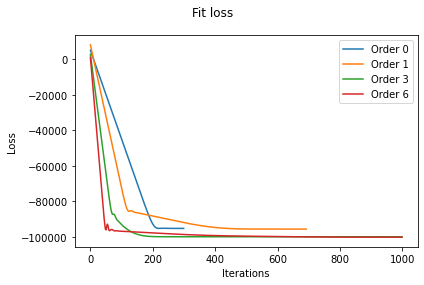

In [106]:
if single_step_iter:
    M_lst = range(M_max)
else:
    M_lst = M_lst
    M_max = np.max(M_lst)

iter_len = len(M_lst)
fig = plt.figure()
val_loss_arr = np.zeros(M_max+1)
coeffs = np.zeros((M_max+1, M_max+1))
fit_rate_fine = np.zeros((M_max+1, len(t_fine)))
print('Time elapsed:\n')

# Iterate through increasing polynomial complexity. 
# Compare fit w/ validation set and use minimum loss find optimal polynomial order.
for i in range(len(M_lst)):    
    # initialize for fit loop
    M = M_lst[i]  # Polynomial order  (e.g., x^2 --> M=2)
    fit_model = Fit_Pulse(M, t_min, t_max, deadtime)
    optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
    epoch = 0
    rel_step = 1e3*rel_step_lim
    fit_loss_lst = []
    val_loss_lst = []
    rel_step_lst = []

    init_C = np.zeros(M+1)
    for j in range(M+1):
        init_C[j] = fit_model.C[j].item()

    # set the loss function to use a Poisson point process likelihood function
    loss_fn = pois_loss

    # perform fit
    start = time.time()
    while rel_step > rel_step_lim and epoch < max_epochs:
        fit_model.train()
        pred_fit, integral_fit = fit_model(t_phot_fit_tnsr, intgrl_N)
        loss_fit = loss_fn(pred_fit, integral_fit*cnt_phot_fit)  # add regularization here
        fit_loss_lst += [loss_fit.item()]

        # calculate relative step as an average over the last
        # term_persist iterations
        if epoch == 0:
            rel_step_lst+=[1e3*rel_step_lim]
            rel_step = 1e3*rel_step_lim
        else:
            rel_step_lst+=[(fit_loss_lst[-2]-fit_loss_lst[-1])/np.abs(fit_loss_lst[-2])]
            rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

        # update estimated parameters
        loss_fit.backward()
        optimizer.step()

        # zero out the gradient for the next step
        optimizer.zero_grad()

        epoch+=1

    # Calculate validation loss
    # Using fit from fit set, calculate loss when applied to validation set
    pred_val, integral_val = fit_model(t_phot_val_tnsr, intgrl_N)
    loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
    val_loss_arr[M] = loss_val
        
    end = time.time()
    print('Order={}: {:.2f} sec'.format(M, end-start))
    
    coeffs[M, 0:M+1] = fit_model.C.detach().numpy().T
    plt.plot(fit_loss_lst, label='Order {}'.format(M))
    
    pred_mod_seg, __ = fit_model(torch.tensor(t_fine), intgrl_N)
    fit_rate_fine[M, :] = pred_mod_seg.detach().numpy().T

plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.suptitle('Fit loss')
plt.tight_layout()
plt.legend()
plt.show()

In [70]:
for i in range(len(M_lst)):
    print('Final validation loss value for order {}: {:.2f}'.format(M_lst[i], val_loss_arr[M_lst[i]]))

Final validation loss value for order 0: -95150.53
Final validation loss value for order 1: -95535.59
Final validation loss value for order 3: -99853.25
Final validation loss value for order 6: -100063.65
Final validation loss value for order 8: -99963.69


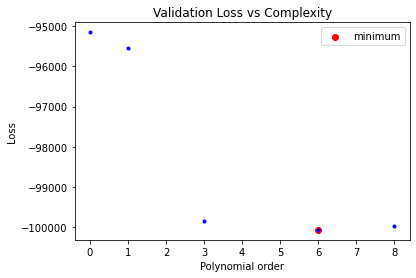

In [71]:
minx, miny = np.argmin(val_loss_arr), min(val_loss_arr)

plt.plot(M_lst, val_loss_arr[M_lst], 'b.')
plt.scatter(minx, miny,c='r', label='minimum')
plt.title('Validation Loss vs Complexity')
plt.ylabel('Loss')
plt.xlabel('Polynomial order')
plt.legend()
plt.show()

In [74]:
# Choose order to investigate
order = 6
try:
    model = coeffs[order, 0:order+1]
    for i in range(order+1):
        print('Final C{}: {:.4f}'.format(i, model[i]))
except:
    print("\nERROR: Order exceeds maximum complexity iteration value.\n")

Final C0: 8.8471
Final C1: 10.3608
Final C2: 3.4588
Final C3: -4.5968
Final C4: -3.8363
Final C5: 3.4361
Final C6: 0.2587


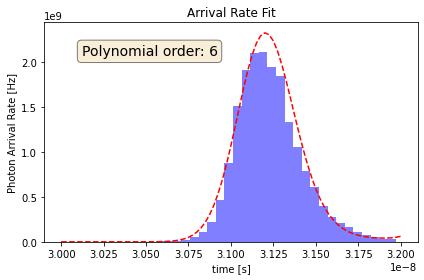

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Scaled histogram
scale = 1e-12
n, bins = np.histogram(flight_time, bins=38)
binwidth = np.diff(bins)[0]
N = n / binwidth / cnt_phot  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='b', alpha=0.5)

# Arrival rate fit
t_fine = np.arange(t_min, t_max, dt)
fit_rate_seg = fit_rate_fine[order, :]
ax.plot(t_fine, fit_rate_seg, 'r--')
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.90, 'Polynomial order: {}'.format(order), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()


### Graveyard ###

In [93]:
class NumericalIntegrator:
    def riemann(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)):
            integral += f(eval_pts[i])
        integral *= dx
        return integral

    def trapezoidal(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-1):
            integral += f(eval_pts[i]) + f(eval_pts[i+1])
        integral *= dx / 2
        return integral

    def simpsons(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-2):
            integral += f(eval_pts[i]) + 4*f(eval_pts[i+1]) + f(eval_pts[i+2])
        integral *= dx / 2 / 3
        return integral
